In [1]:
#this allows plots to be displayed inline with the notebook
%matplotlib inline 

In [2]:
import pathlib

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from esi_utils_pager.semimodel import SemiEmpiricalFatality,URBAN,RURAL,pop_dist

Create a SemiEmpiricalFatality object from default files in the repository.

In [5]:
semi = SemiEmpiricalFatality.fromDefault()

Establish the parameters which we'd like to test - country code, time of day, population density, input population, and MMI.

In [6]:
ccode = 'ID' #Indonesia
timeofday = 'day'
density = URBAN
pop = 100000
mmi = 8.5

The <a http://earthquake.usgs.gov/data/pager/prodandref/Jaiswal_Wald_2010_Semi.pdf>paper</a> describing this model in full says that Indonesia daytime residential/non-residential populations should be about 22% and 43% of the total respectively (the remainder are outdoors, and therefore relatively safe from shaking.)   

In [7]:
workforce = semi.getWorkforce(ccode)
res,nonres,outside = pop_dist(pop,workforce,timeofday,density)
print(workforce)
print('Daytime Residential Population of %s: %s' % (ccode,format(int(res[0]),',d')))
print('Daytime Non-Residential Population of %s: %s' % (ccode,format(int(nonres[0]),',d')))

CountryName              Indonesia
WorkForceTotal               0.461
WorkForceAgricultural        0.433
WorkForceIndustrial           0.18
WorkForceServices            0.387
Name: ID, dtype: object
Daytime Residential Population of ID: 22,021
Daytime Non-Residential Population of ID: 43,525


Retrieve the residential/non-residential urban inventories for Indonesia - these are returned as Pandas Series objects

In [8]:
resinv,nonresinv = semi.getInventories(ccode,density)
print('Residential:')
print(resinv)
print()
print('Non-Residential:')
print(nonresinv)

Residential:
C2       0.1
C3      0.15
PC2     0.03
S5      0.05
UCB      0.4
UFB4    0.12
W        0.1
W1      0.05
Name: ID, dtype: object

Non-Residential:
C2      0.15
C3      0.35
PC2     0.04
S2      0.17
S5      0.14
UCB      0.1
UFB4    0.05
Name: ID, dtype: object


Retrieve the collapse rates for both inventories at MMI 8.5.

In [9]:
res_collapse = semi.getCollapse(ccode,mmi,resinv)
nonres_collapse = semi.getCollapse(ccode,mmi,nonresinv)
print('Residential Collapse Rates:')
print(res_collapse)
print()
print('Non-Residential Collapse Rates:')
print(nonres_collapse)

Residential Collapse Rates:
C2      0.0100
C3      0.0650
PC2     0.1050
S5      0.0075
UCB     0.0650
UFB4    0.1270
W       0.0750
W1      0.0225
Name: MMI_8.5, dtype: float64

Non-Residential Collapse Rates:
C2      0.0100
C3      0.0650
PC2     0.1050
S2      0.0250
S5      0.0075
UCB     0.0650
UFB4    0.1270
Name: MMI_8.5, dtype: float64


Retrieve the daytime fatality rates given collapse for both inventories.

In [10]:
res_fat_rates = semi.getFatalityRates(ccode,timeofday,resinv)
nonres_fat_rates = semi.getFatalityRates(ccode,timeofday,nonresinv)
print('Residential Fatality Rates:')
print(res_fat_rates)
print()
print('Non-Residential Fatality Rates:')
print(nonres_fat_rates)

Residential Fatality Rates:
C2      0.150
C3      0.150
PC2     0.150
S5      0.140
UCB     0.080
UFB4    0.080
W       0.007
W1      0.007
Name: CasualtyDay, dtype: float64

Non-Residential Fatality Rates:
C2      0.15
C3      0.15
PC2     0.15
S2      0.14
S5      0.14
UCB     0.08
UFB4    0.08
Name: CasualtyDay, dtype: float64


Now we can multiply the residential/non-residential populations through the inventory, collapse, and fatality rates.

In [11]:
res_fats = res * resinv * res_collapse * res_fat_rates
nonres_fats = nonres * nonresinv * nonres_collapse * nonres_fat_rates
print('Residential Fatalities:')
print(res_fats)
print()
print('Non-Residential Fatalities:')
print(nonres_fats)
print()
resfatsum = int(res_fats.sum())
nonresfatsum = int(nonres_fats.sum())
print('Total Residential Fatalities: %s' % (format(resfatsum,',d')))
print('Total Non-Residential Fatalities: %s' % (format(nonresfatsum,',d')))
print('Total Fatalities: %s' % (format(nonresfatsum+resfatsum,',d')))

Residential Fatalities:
C2        3.30315
C3      32.205713
PC2     10.404922
S5       1.156103
UCB      45.80368
UFB4    26.848003
W        1.156103
W1       0.173415
dtype: object

Non-Residential Fatalities:
C2        9.793189
C3      148.530035
PC2       27.42093
S2       25.897545
S5        6.398217
UCB      22.633148
UFB4     22.110845
dtype: object

Total Residential Fatalities: 121
Total Non-Residential Fatalities: 262
Total Fatalities: 383


Let's compare the occupancy rates for Indonesia to the fatality rates for those same building types at our chosen MMI of 8.5

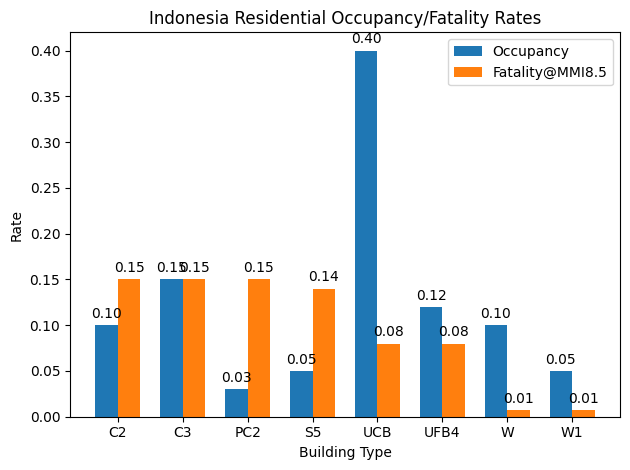

In [12]:
labels = list(resinv.index)
inventory = resinv.values
fatality_rates = res_fat_rates.values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, inventory, width, label='Occupancy')
rects2 = ax.bar(x + width/2, fatality_rates, width, label='Fatality@MMI8.5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Building Type')
ax.set_ylabel('Rate')
ax.set_title('Indonesia Residential Occupancy/Fatality Rates')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()

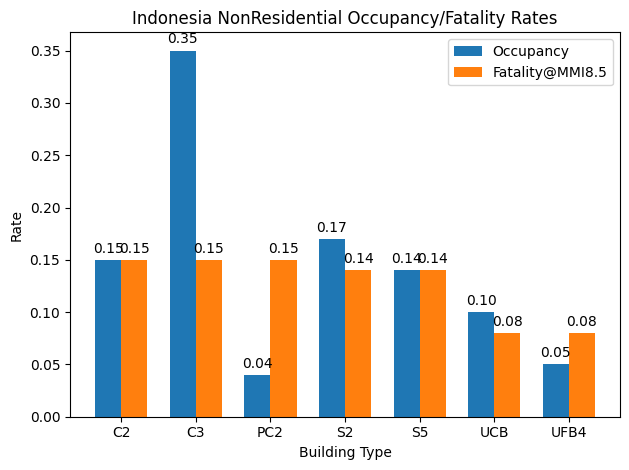

In [13]:
labels = list(nonresinv.index)
inventory = nonresinv.values
fatality_rates = nonres_fat_rates.values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, inventory, width, label='Occupancy')
rects2 = ax.bar(x + width/2, fatality_rates, width, label='Fatality@MMI8.5')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Building Type')
ax.set_ylabel('Rate')
ax.set_title('Indonesia NonResidential Occupancy/Fatality Rates')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt="%.2f")
ax.bar_label(rects2, padding=3, fmt="%.2f")

fig.tight_layout()

plt.show()